# Lab 01 — From Machine Learning to AI?

## Section 0 — Can Machines Think?

> **“Can machines think?”**  
> In 1950, Alan Turing reframed this question as a simple game: put a human judge in a room with two hidden interlocutors—one human, one machine—and see if the judge can tell them apart. If not, the machine “passes” the test and is deemed intelligent.

That bold idea kicked off **artificial intelligence**. Since then, innovations in theory, algorithms, and hardware have spawned entire fields:

- **Computer Vision** ▸ Can machines “see” the world like we do?  
- **Natural Language Processing** ▸ Can machines understand and generate human language?  
- **Robotics** ▸ Can machines move and interact in physical environments?  
- **Forecasting** ▸ Can machines predict tomorrow’s outcomes as well as—or better than—experts?

…and many more areas exploring how machines can perceive, reason, and act.

Today’s breakthroughs—like convolutional nets for images, transformers for language, and diffusion models for creativity—bring us closer than ever to “thinking” machines. Sometimes they even outperform humans on specific tasks. But **how did we get here?**

---

In **Lab 01**, we’ll retrace the **153-year journey** from  
- **Linear Regression** (Legendre, 1805)  
to  
- **The Perceptron** (Rosenblatt, 1958)  

Over **15 hours** of hands-on exercises, you will:

- Derive and implement **least-squares regression** from scratch  
- Compare the closed-form solution to **stochastic gradient descent**  
- Build and train a **single-layer perceptron**  
- Upgrade to a **two-layer MLP** using PyTorch  
- Measure and compare **loss curves**, **accuracy**, **parameter counts**, and **FLOPs**

By the end, you’ll see exactly how simple linear models evolved into modern neural networks—and gain the skills to train them yourself.


In [13]:
# Make sure you use efficientai conda kernel and it contains the required packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression, RANSACRegressor
# you also need to install nbformat

## Section 1 — Rethinking Linear Regression

> **“When I say fundamental, I do not mean easy.”**  
> — Richard Feynman

Linear regression may be the simplest predictive model, yet it hides the core ideas behind every modern ML algorithm:

- **Weights & Bias** ▸ How do we adjust model parameters to fit data?  
- **Loss Function (MSE)** ▸ How do we quantify “goodness of fit”?  
- **Gradient Descent** ▸ How do we iteratively improve our model when no closed-form solution exists?

In this section you will:

1. **Derive** the closed-form least-squares solution.  
2. **Implement** linear regression from scratch in NumPy.  
3. **Compare** analytic solutions to stochastic gradient descent.  

By the end, you’ll see how these building blocks scale up to deep neural networks—and why mastering them is essential for efficient AI.  

**Task Description: Predicting Exam Performance by Eye**

You are an educational researcher looking for a simple rule to estimate a student’s exam score based on how many hours they studied. You have data from 15 students:

| Hours Studied | Exam Score (%) |
|---------------|----------------|
| 1             | …              |
| 2             | …              |
| …             | …              |
| 10            | …              |

Rather than immediately relying on a mathematical formula, your first job is to **use your intuition** to find a relationship of the form  
$$
\text{predicted score} = w \times (\text{hours}) + b
$$  
that seems to roughly pass through the cloud of points.  

- **Why?** By manually adjusting $w$ (the “points per hour” rate) and $b$ (the baseline score) you’ll develop a feel for how slope and intercept control the model’s predictions.  
- **How?** Run the provided code cell, tweak the values of `w` and `b`, and observe how your line moves relative to the data.  
- **Goal:** Find values of $w$ and $b$ that you believe would give reasonably accurate score predictions—without yet using any automated fitting method.  

This exercise builds your intuition for how linear regression parameters shape the fit before we dive into the formal derivations and algorithms.  


   hours_studied  exam_score
0       1.000000   63.320262
1       1.642857   59.393643
2       2.285714   65.179404
3       2.928571   74.383037
4       3.571429   75.409219


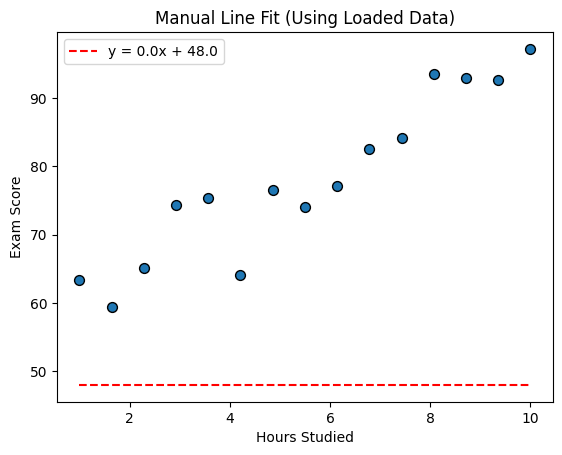

In [2]:
# 1) Load the data
df_loaded = pd.read_csv("hours_vs_score.csv")
print(df_loaded.head())

# 2) Manually choose your line parameters (edit these!)
w = 0.0    # slope
b = 48.0   # intercept

# 3) Plot data and your line using the loaded DataFrame
plt.scatter(df_loaded["hours_studied"], df_loaded["exam_score"], s=50, edgecolor='k')
x = np.linspace(df_loaded["hours_studied"].min(), df_loaded["hours_studied"].max(), 100)
plt.plot(x, w * x + b, 'r--', label=f"y = {w:.1f}x + {b:.1f}")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Manual Line Fit (Using Loaded Data)")
plt.legend()
plt.show()


### From “By Eye” to “Best Fit”

Now that you’ve placed a line by eye, we need a **precise criterion** for what makes one line better than another.

#### 1. **Error for a single student**  
   For student *i* with hours $x_i$ and actual score $y_i$, if our prediction is  
   $$\hat y_i = w\,x_i + b,$$  
   then the **prediction error** is  
   $$e_i = y_i - \hat y_i.$$

#### 2. **Aggregating errors**  
   We want one number that summarizes how well the line fits **all** *n* students. Common choices include:  
   - **Mean Absolute Error (MAE):**  
     $$\frac{1}{n}\sum_{i=1}^n \bigl|e_i\bigr|$$  
   - **Mean Squared Error (MSE):**  
     $$\frac{1}{n}\sum_{i=1}^n e_i^2$$



### Comparing MSE vs. MAE

Below is a plot of the two most common regression losses as a function of the prediction error \(e\):

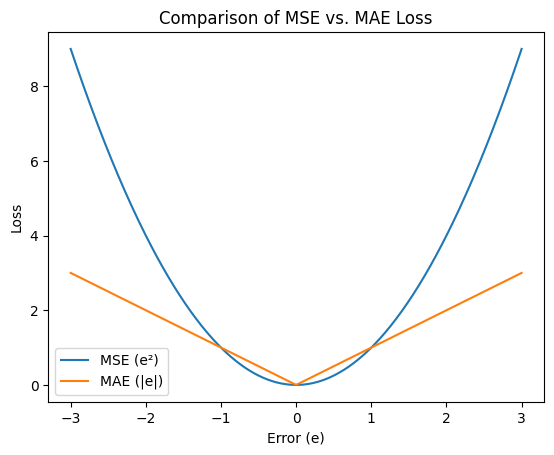

In [3]:
errors = np.linspace(-3, 3, 400)

# Compute MAE and MSE
mae = np.abs(errors)
mse = errors**2

# Plot both losses
plt.plot(errors, mse, label="MSE (e\u00b2)")
plt.plot(errors, mae, label="MAE (|e|)")
plt.xlabel("Error (e)")
plt.ylabel("Loss")
plt.title("Comparison of MSE vs. MAE Loss")
plt.legend()
plt.show()

| Loss        | Formula      | Shape          | Sensitivity to outliers | Gradient behavior     |
|-------------|--------------|----------------|-------------------------|-----------------------|
| **MSE**     | \(e^2\)      | Quadratic      | High (large errors get squared) | Smooth and continuous; large gradients for big errors |
| **MAE**     | \(\lvert e\rvert\) | Linear        | Moderate (errors weighted equally) | Piecewise constant gradient; nondifferentiable at \(e=0\) |

(i). **Quadratic vs. Linear**  
   - MSE grows as the *square* of the error, so a single large mistake can dominate the loss.  
   - MAE grows in direct proportion to the error, so all mistakes contribute evenly.

(2). **Outlier impact**  
   - With MSE, outliers (very large residuals) heavily influence the fitted model, since squaring magnifies their effect.  
   - MAE is more robust: all residuals count the same per unit error.

(3). **Optimization considerations**  
   - MSE’s smooth derivative (\(2e\)) makes gradient-based optimization straightforward and stable.  
   - MAE’s derivative is \(\pm1\) (undefined exactly at 0), which can slow convergence or require specialized solvers.

**When to use which?**

- Use **MSE** if you want your model to focus on reducing large errors and benefit from smooth gradients.  
- Use **MAE** if you need robustness against outliers or if absolute deviations are more meaningful for your application.


#### 3. **Defining “Best”**  
   The “best” line $(w^*, b^*)$ is the one that **minimizes** our chosen aggregate error. For MSE:  
   $$
   (w^*,b^*) = \arg\min_{w,b}\;\frac{1}{n}\sum_{i=1}^n\bigl(y_i - (w\,x_i + b)\bigr)^2.
   $$

#### 4 — A Solution?

We have data $(x_i, y_i)$ for $i = 1, \dots, n$. Our goal is to find

$$
(w^*, b^*) = \arg\min_{w,b} \; \frac{1}{n} \sum_{i=1}^n \bigl(y_i - (w\,x_i + b)\bigr)^2.
$$

Because this loss is convex in $w$ and $b$, the minimum occurs where its first derivatives vanish.

Setting the partial derivatives to zero gives the normal equations:

$$
\begin{aligned}
\frac{\partial}{\partial w}:&\quad -\frac{2}{n} \sum_{i=1}^n x_i \bigl(y_i - (w\,x_i + b)\bigr) = 0,\\
\frac{\partial}{\partial b}:&\quad -\frac{2}{n} \sum_{i=1}^n \bigl(y_i - (w\,x_i + b)\bigr) = 0.
\end{aligned}
$$

Solving these yields the closed-form least-squares solution:

$$
\begin{aligned}
w^* &= \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2},\\
b^* &= \bar{y} - w^*\,\bar{x},
\end{aligned}
$$

where

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i,
\quad
\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i.
$$

Now it seems like that we have a best solution candidate, can you calculate the closed form least square solution using code?


Least-squares: y = 0.00x + 0.00


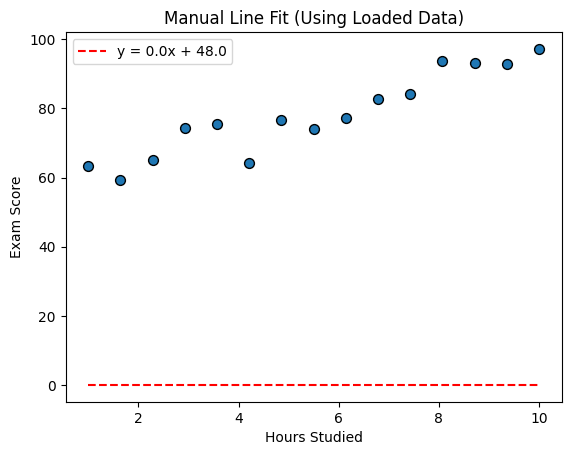

In [4]:
# Load the data
df = pd.read_csv("hours_vs_score.csv")

# 1) Please implement the least-squares solution here
x_mean, y_mean = 0,0
w_ls = 0
b_ls = 0

print(f"Least-squares: y = {w_ls:.2f}x + {b_ls:.2f}")

# The least-squares solution should be pretty good if you implemented it correctly.
plt.scatter(df_loaded["hours_studied"], df_loaded["exam_score"], s=50, edgecolor='k')
x = np.linspace(df_loaded["hours_studied"].min(), df_loaded["hours_studied"].max(), 100)
plt.plot(x, w_ls * x + b_ls, 'r--', label=f"y = {w:.1f}x + {b:.1f}")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Manual Line Fit (Using Loaded Data)")
plt.legend()
plt.show()

### Open-Ended Questions: Beyond the Closed-Form Fit

1. **Units Matter**  
   - If you measured study time in **minutes** instead of hours, what are the new values of $w^*$ and $b^*$?  
   - What does this tell you about the relationship between your model’s parameters and the data’s units?

2. **Polynomial Extensions**  
   - Real-world relationships aren’t always linear. Derive and solve the closed-form normal equations for a **quadratic** model  
     $
       \hat y = a\,x^2 + b\,x + c
     $  
     on the same data.  
   - How does the predictive performance (e.g. on a held-out validation split) compare between the straight-line and quadratic fits?

3. **Sensitivity to Data Changes**  
   - Remove one or two data points (for example, the smallest or largest study times), recompute $(w^*, b^*)$, and observe how the fitted line shifts.  
   - Which points have the greatest influence on your model’s predictions, and what does that imply for the reliability of a single linear rule?  

4. **Choise of Loss**
   - Can you find other loss functions?
   - How does it impact your final results?

Try to write some code below to visualize and demonstrate your point!

### From One Dimension to High Dimension

So far we’ve fit a straight line $\hat y = w x + b$ to one feature. In real applications, we often have **many** features and want to predict a target variable. 

> **Note:** The next section uses basic linear algebra and multivariable calculus to extend our 1D solution into matrix form. This generalized linear model is foundational in machine learning—feel free to explore it now or skip ahead and revisit later when you’re comfortable.

Here’s how the theory generalizes:



#### 1 Notation & Model


- **Features**: instead of a single “hours studied” $x_i$, each data point has a vector of $d$ features  
  $\mathbf{x}_i = [\,x_{i1},\,x_{i2},\,\dots,\,x_{id}\,]^\top$.  
- **Parameters**: weights become a $d$-dimensional vector $\mathbf{w}$, plus a bias $b$.  
- **Prediction**:  
  $$\hat y_i = \mathbf{w}^\top \mathbf{x}_i + b.$$

Let each data point have \(d\) features.  Stack \(n\) points into a matrix:

$$
X = \begin{pmatrix}
x_{11} & x_{12} & \dots  & x_{1d} \\
x_{21} & x_{22} & \dots  & x_{2d} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots  & x_{nd}
\end{pmatrix}
\in \mathbb{R}^{n\times d},
\quad
\mathbf{y} = \begin{pmatrix}
y_1 \\ y_2 \\ \vdots \\ y_n
\end{pmatrix}
\in \mathbb{R}^n.
$$

To include the bias \(b\), prepend a column of ones:

$$
\widetilde{X} = \begin{pmatrix}
1 & x_{11} & x_{12} & \dots  & x_{1d} \\
1 & x_{21} & x_{22} & \dots  & x_{2d} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{n1} & x_{n2} & \dots  & x_{nd}
\end{pmatrix}
\in \mathbb{R}^{n\times (d+1)}.
$$

The parameter vector (bias + weights) is

$$
\widetilde{\mathbf{w}} = 
\begin{pmatrix}
b \\ w_1 \\ \vdots \\ w_d
\end{pmatrix}
\in \mathbb{R}^{(d+1)}.
$$

Our predictions are simply

$$
\hat{\mathbf{y}} = \widetilde{X}\,\widetilde{\mathbf{w}}
\quad\Longrightarrow\quad
\hat y_i = b + w_1\,x_{i1} + \dots + w_d\,x_{id}.
$$

#### 2 Loss & Closed-Form Solution

- **Mean Squared Error** over $n$ points:  
  $$L(\mathbf{w},b) = \tfrac{1}{n}\sum_{i=1}^n \bigl(y_i - (\mathbf{w}^\top\mathbf{x}_i + b)\bigr)^2.$$
- **Matrix form**: let $X\in\mathbb{R}^{n\times d}$ have rows $\mathbf{x}_i^\top$, and $\mathbf{y}\in\mathbb{R}^n$.  Augment $X$ with a column of ones to include $b$:  
  $$\widetilde X = [\,\mathbf{1}\;\;X\,],\quad \widetilde{\mathbf{w}} = \begin{bmatrix}b\\\mathbf{w}\end{bmatrix},\quad \hat{\mathbf{y}} = \widetilde X\,\widetilde{\mathbf{w}}.$$
- **Normal equations**:  
  $$\widetilde X^\top \widetilde X\,\widetilde{\mathbf{w}} = \widetilde X^\top \mathbf{y}.$$
- **Closed-form solution** (when invertible):  
  $$\widetilde{\mathbf{w}}^* = (\widetilde X^\top\widetilde X)^{-1}\,\widetilde X^\top\,\mathbf{y}.$$


We now visulize the 3 dimensional Linear Regression in code:

In [ ]:
# Generate more scattered synthetic 3D data
np.random.seed(42)
n = 100
x1 = np.random.uniform(0, 10, n)
x2 = np.random.uniform(0, 10, n)
true_w1, true_w2, true_b = 2.5, -1.5, 5.0
z = true_w1 * x1 + true_w2 * x2 + true_b + np.random.randn(n) * 5  # increased noise

# Fit plane via closed-form solution
X = np.column_stack([np.ones(n), x1, x2])
w = np.linalg.inv(X.T @ X) @ X.T @ z

# Create grid for fitted plane
grid_x1, grid_x2 = np.meshgrid(np.linspace(0, 10, 20), np.linspace(0, 10, 20))
grid_z = w[0] + w[1] * grid_x1 + w[2] * grid_x2

# Build interactive 3D plot
scatter = go.Scatter3d(
    x=x1, y=x2, z=z, mode='markers',
    marker=dict(size=4, color='blue', opacity=0.7)
)
surface = go.Surface(
    x=grid_x1, y=grid_x2, z=grid_z, opacity=0.5
)

fig = go.Figure(data=[scatter, surface])
fig.update_layout(
    scene=dict(
        xaxis_title='Feature x1',
        yaxis_title='Feature x2',
        zaxis_title='Target z'
    ),
    title='Interactive 3D Linear Regression: Scattered Data and Fitted Plane'
)
fig.show()


*This interactive plot shows a cloud of 3D data points (blue markers) generated from two features, and the semi-transparent plane is the closed-form least-squares fit. You can rotate and zoom to see how the plane minimizes the squared vertical distances of all points, generalizing the idea of a best-fit line from 1D to a best-fit hyperplane in higher dimensions.*


#### When Closed-Form Fails: An Optimization Approach

##### 1 Limitations of the Closed-Form Solution
- **Computational cost**  
  Computing the formula  
  $$
    w^* = (X^T X)^{-1} X^T y
  $$  
  requires inverting a $d\times d$ matrix in $O(d^3)$ time. When $d$ is large (thousands–millions of features), this becomes infeasible.
- **Singularity & Ill-conditioning**  
  If $X^T X$ is singular or nearly singular (for example, when $d>n$ or features are highly correlated), the inverse does not exist or is numerically unstable.
- **Rigid to extensions**  
  The closed form only works for plain MSE. As soon as you add L1/L2 regularization, Huber loss, or other penalties, there is no simple analytic solution.
- **Not online / incremental**  
  You must load the entire dataset and solve in one shot; you cannot easily update your model as new data arrives or process data in mini-batches.

These drawbacks motivate an iterative approach: **gradient descent**.


##### 2 Gradient Descent for Linear Regression

Gradient descent turns the one-shot solution into a repeated update, each step costing only $O(n\,d)$.

1. **Define the loss**  
   $$
     L(w,b) = \frac{1}{n}\sum_{i=1}^n \bigl(y_i - (w\,x_i + b)\bigr)^2.
   $$

2. **Compute gradients**  
   $$
     \frac{\partial L}{\partial w}
     = -\frac{2}{n}\sum_{i=1}^n x_i\bigl(y_i - (w\,x_i + b)\bigr),
   $$  
   $$
     \frac{\partial L}{\partial b}
     = -\frac{2}{n}\sum_{i=1}^n \bigl(y_i - (w\,x_i + b)\bigr).
   $$

3. **Update rule**  
   Initialize $w,b$ (for example, to zero), pick a small learning rate $\eta$, then repeat for $T$ steps:

   ```python
   for t in range(T):
       y_pred = w * x + b
       error  = y - y_pred

       grad_w = (-2/n) * (x * error).sum()
       grad_b = (-2/n) * error.sum()

       w -= eta * grad_w
       b -= eta * grad_b
```
```
Each iteration moves $(w,b)$ “downhill” on the loss surface.

4. **Convergence**

   * With a suitable $\eta$, gradient descent converges to the same $(w^*,b^*)$ as the closed-form solution—without ever inverting a matrix.
   * Variants like **stochastic** or **mini-batch** gradient descent let you train on streaming data or very large datasets.


**Bottom line:** Gradient descent scales to large, regularized, and non-linear models (including neural networks), making it the workhorse of modern machine learning—even when a closed-form solution exists.

Now we implement and visualize Gradient descent using the hours_vs_score.csv dataset:

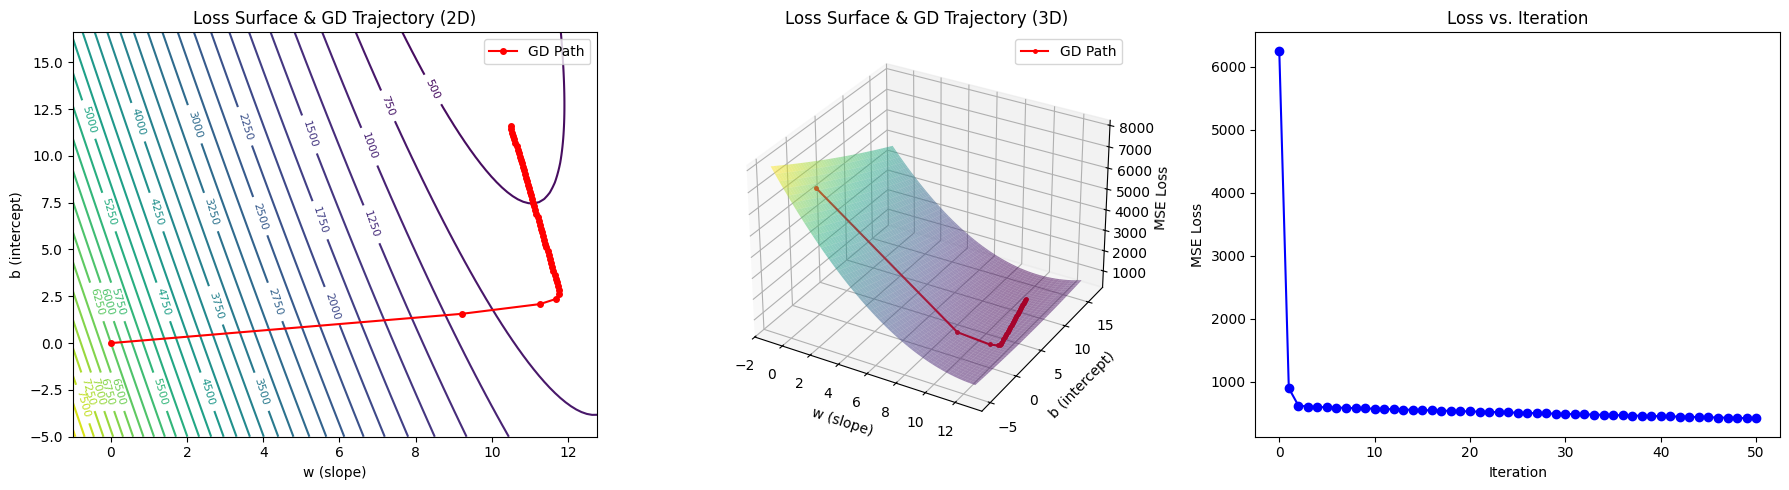

In [ ]:

# 1) Load data
df = pd.read_csv("hours_vs_score.csv")
x = df["hours_studied"].values
y = df["exam_score"].values
n = len(x)

# 2) Define MSE loss
def mse_loss(w, b):
    return np.mean((y - (w * x + b))**2)

# 3) Gradient descent parameters and trajectory
lr, epochs = 0.01, 50
w, b = 0.0, 0
trajectory = [(w, b, mse_loss(w, b))]
for _ in range(epochs):
    error = y - (w * x + b)
    grad_w = -2/n * np.sum(x * error)
    grad_b = -2/n * np.sum(error)
    w -= lr * grad_w
    b -= lr * grad_b
    trajectory.append((w, b, mse_loss(w, b)))
ws, bs, losses = zip(*trajectory)

# 4) Prepare grid for surface and contour
w_vals = np.linspace(min(ws)-1, max(ws)+1, 100)
b_vals = np.linspace(min(bs)-5, max(bs)+5, 100)
W, B = np.meshgrid(w_vals, b_vals)
Z = np.array([mse_loss(wi, bi) for wi, bi in zip(np.ravel(W), np.ravel(B))]).reshape(W.shape)

# 5) Plot three graphs side by side
fig = plt.figure(figsize=(18, 5))

# 5a) Contour plot with labels
ax1 = fig.add_subplot(1, 3, 1)
cs = ax1.contour(W, B, Z, levels=30, cmap='viridis')
ax1.clabel(cs, inline=True, fontsize=8)
ax1.plot(ws, bs, 'ro-', markersize=4, label='GD Path')
ax1.set_xlabel('w (slope)')
ax1.set_ylabel('b (intercept)')
ax1.set_title('Loss Surface & GD Trajectory (2D)')
ax1.legend()

# 5b) 3D surface plot
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(W, B, Z, alpha=0.5, cmap='viridis')
ax2.plot(ws, bs, losses, 'r.-', markersize=5, label='GD Path')
ax2.set_xlabel('w (slope)')
ax2.set_ylabel('b (intercept)')
ax2.set_zlabel('MSE Loss')
ax2.set_title('Loss Surface & GD Trajectory (3D)')
ax2.legend()

# 5c) Loss vs iteration
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(range(len(losses)), losses, 'b-o')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('MSE Loss')
ax3.set_title('Loss vs. Iteration')

plt.tight_layout()
plt.show()

##### Combined Visualization: Contour, 3D Surface, and Loss Curve

The figure above shows three views of gradient descent on our “hours vs. score” data:

1. **Loss Surface & GD Trajectory (2D Contour)**  
   - Contour lines represent MSE values for different \((w,b)\).  
   - Red dots and lines trace each gradient descent update, moving toward lower-loss regions (as annotated by the contour labels).

2. **Loss Surface & GD Trajectory (3D Surface)**  
   - The same MSE surface in 3D, with the descent path plotted in red.  
   - You can see how the algorithm “slides” down the slope of the surface to the minimum.

3. **Loss vs. Iteration**  
   - Tracks the MSE value at each step.  
   - Notice the steep initial drop followed by gradual convergence to the optimal loss.

Together, these plots demonstrate that gradient descent reliably finds the closed-form solution by iteratively moving downhill—no matrix inversion required.  


#### Is Linear Regression the One-For-All Solution?

Linear regression is a powerful, simple starting point—but it has clear limits:

1. **Non-linear relationships**  
   - If the true pattern in your data curves or wiggles, a straight line (or hyperplane) will systematically under- or over-estimate in different regions.  
   - You’ll see clusters of large residuals where the model misses the curve.


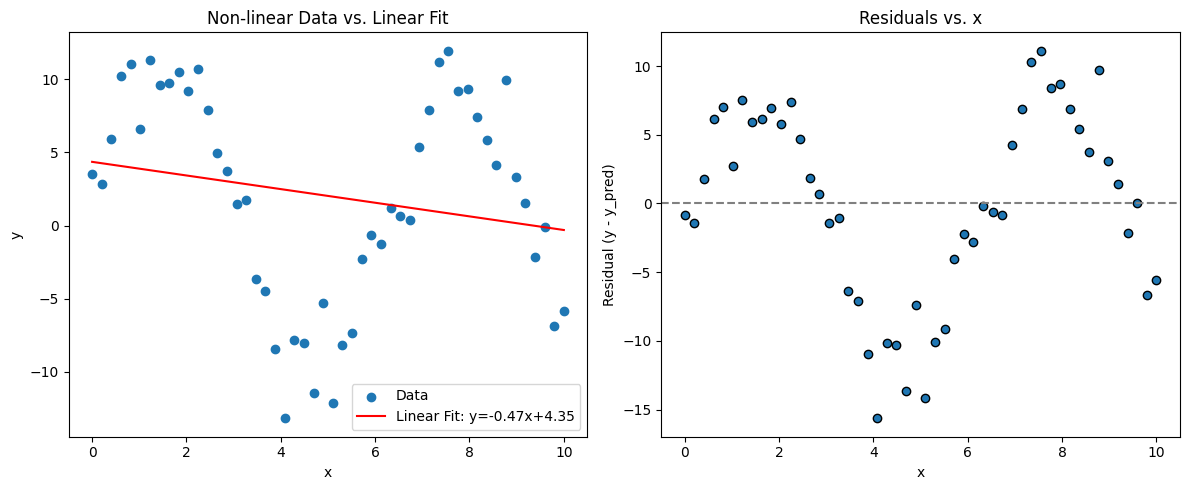

In [11]:
np.random.seed(0)
x = np.linspace(0, 10, 50)
y = np.sin(x) * 10 + np.random.randn(50) * 2  # sine-pattern + noise

# Fit linear regression (closed-form)
X = np.vstack([x, np.ones_like(x)]).T
w, b = np.linalg.inv(X.T @ X) @ X.T @ y

# Predictions and residuals
y_pred = w * x + b
residuals = y - y_pred

# Plot data and linear fit
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x, y, label='Data')
plt.plot(x, y_pred, 'r-', label=f'Linear Fit: y={w:.2f}x+{b:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Non-linear Data vs. Linear Fit')
plt.legend()

# Plot residuals
plt.subplot(1, 2, 2)
plt.scatter(x, residuals, edgecolor='k')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('x')
plt.ylabel('Residual (y - y_pred)')
plt.title('Residuals vs. x')

plt.tight_layout()
plt.show()


2. **Too Few vs. Too Many Features**

- **Underdetermined (d ≫ n)**  
  In our example, we had 3 data points but 5 features (`X` is 3×5). After computing one pseudoinverse solution `w0`, we found a nonzero null‐space vector `v` and formed `w1 = w0 + v`. Both satisfy  
```python
  X @ w0 ≈ y    # zero residual
  X @ w1 ≈ y    # zero residual
```
   because any vector in the null space can be added and still solve `Xw = y`.
   **Consequence:** Infinitely many exact fits—no unique inverse. To pick one, you must impose extra constraints (e.g. L2 regularization) or gather more data.

* **Overdetermined (n ≫ d)**
  Here we had 10 data points but only 2 features (`X2` is 10×2). The closed‐form least‐squares solution `w2 = (X2ᵀX2)⁻¹X2ᵀy2` minimizes the residuals, but
```python
  residual = X2 @ w2 - y2
  ||residual|| > 0
```
  because there is no exact solution when the data doesn’t lie perfectly on a plane.
  **Consequence:** You get a unique “best‐fit” hyperplane but it underfits if the true relationship is more complex.

```



In [12]:
import numpy as np

# 1) Underdetermined system: more variables (d) than equations (n)
np.random.seed(0)
n, d = 3, 5
X = np.random.randn(n, d)           # 3 equations, 5 unknowns
y = np.random.randn(n)              # arbitrary right‐hand side

# Compute one least‐norm solution via pseudo‐inverse
w0 = np.linalg.pinv(X) @ y

# Find a nonzero vector in the nullspace of X
U, S, Vt = np.linalg.svd(X)
null_space = Vt.T[:, S.size:]       # basis for nullspace has dimension d - rank(X)
v = null_space[:, 0] if null_space.size > 0 else np.zeros(d)

# Another valid solution
w1 = w0 + v

# Check both fit exactly (X @ w ≈ y)
print("Underdetermined: X@w0 - y =", np.round(X @ w0 - y, 6))
print("               X@w1 - y =", np.round(X @ w1 - y, 6))
print("Any multiple of v added to w0 still fits perfectly!")

# 2) Overdetermined system: more equations (n2) than variables (d2)
n2, d2 = 10, 2
X2 = np.random.randn(n2, d2)        # 10 equations, 2 unknowns
y2 = np.random.randn(n2)            # arbitrary y2

# Compute least‐squares solution
w2 = np.linalg.inv(X2.T @ X2) @ X2.T @ y2

# Compute residuals (won't be zero if y2 is not in the column space of X2)
residual = X2 @ w2 - y2
print("\nOverdetermined: residual norm =", np.linalg.norm(residual))
print("The nonzero residual shows no exact solution exists for all equations.")


Underdetermined: X@w0 - y = [-0.  0.  0.]
               X@w1 - y = [-0.  0.  0.]
Any multiple of v added to w0 still fits perfectly!

Overdetermined: residual norm = 2.7603080545634158
The nonzero residual shows no exact solution exists for all equations.


3. **Outliers and noise**  
   - A few bad points can drag the line significantly (especially under MSE).  
   - Robust alternatives (MAE, Huber) or outlier detection may be needed.

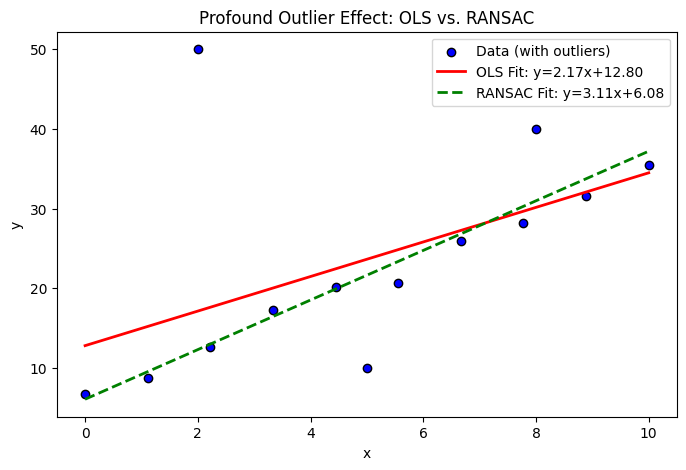

In [14]:
# Generate fewer inlier data points
np.random.seed(0)
x = np.linspace(0, 10, 10)
y = 3 * x + 5 + np.random.randn(10) * 1  # stronger linear trend, less noise

# Introduce extreme outliers
x_out = np.array([2, 5, 8])
y_out = np.array([50, 10, 40])  # extreme values
x_all = np.concatenate([x, x_out])
y_all = np.concatenate([y, y_out])

# Sort for plotting
sorted_idx = np.argsort(x_all)
x_all_sorted = x_all[sorted_idx]
y_all_sorted = y_all[sorted_idx]

# Reshape for sklearn
X_all = x_all_sorted.reshape(-1, 1)

# Fit OLS (MSE)
lr = LinearRegression()
lr.fit(X_all, y_all_sorted)
y_pred_lr = lr.predict(X_all)

# Fit robust RANSAC
ransac = RANSACRegressor(LinearRegression(), random_state=0)
ransac.fit(X_all, y_all_sorted)
y_pred_ransac = ransac.predict(X_all)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x_all, y_all, color='blue', label='Data (with outliers)', edgecolor='k')
plt.plot(x_all_sorted, y_pred_lr, 'r-', linewidth=2, label=f'OLS Fit: y={lr.coef_[0]:.2f}x+{lr.intercept_:.2f}')
plt.plot(x_all_sorted, y_pred_ransac, 'g--', linewidth=2, label=f'RANSAC Fit: y={ransac.estimator_.coef_[0]:.2f}x+{ransac.estimator_.intercept_:.2f}')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Profound Outlier Effect: OLS vs. RANSAC")
plt.legend()
plt.show()


The plot compares two fits on a small dataset with three extreme outliers:

- **Red line (Ordinary Least Squares / MSE)**  
  Pulled strongly toward the outliers, resulting in a poor fit for the main data cluster. With so few “inlier” points, just a handful of extreme values dramatically skews the slope and intercept.

- **Green dashed line (RANSAC / Robust Regression)**  
  Automatically identifies and ignores outliers during fitting, capturing the true underlying trend of the majority of points.


4. **Extensions require new methods**  
   - Adding regularizers, custom losses, or non-convex models (neural nets) breaks the closed-form.  
   - Iterative solvers (gradient descent and its variants) become essential.



**Takeaway:** Linear regression teaches core ideas (weights, bias, loss), but it’s not a “one-for-all” tool. Always check your data’s shape, test residuals for patterns, and be ready to move beyond straight lines when you need more flexibility or robustness.  


### Open-Ended Questions & Next Steps

1. **Beyond Straight Lines**  
   - Can you try to generate nonlinear data and do gradient descent to fit a straight line? Plot the loss curve and the MSE to assess convergence of gradient descent? 

2. **Different Gradient Descent**  
   - Try to explore and implement one other gradient descent variants. How it is different from gradient descent? Is it converging faster? How its path different from gradient descent on the loss surface? 

5. **Theory lover**  
   - Will gradient descent always work? If you are carefull enough, you will notice two hyperparameter that we choose arbitrarily: learning rate, and maximum steps. How many steps does it need in order to converge? How does different learning rate effect convergence? Is there an optimal learning rate that we can choose? 



## Section 2: From Linearity To Non-Linearity

## Capturing Non-Linearity: Step by Step

Can we extend this linear model to capture non-linear relationship? A simple idea is to add a non-linear function at the end to break linearity. Let's experiment with this idea! Here we use ReLU function as the example activation function.

1. **Linear Fit (Red)**  
   - A straight line can only model constant slope. It minimizes squared error but can’t bend to follow curves like a sine wave.  
   - We compute the best line via the closed-form solution  
     ```  
     w*, b* = (Xᵀ X)⁻¹ Xᵀ y  
     ```  
     yet it still underfits whenever the true function isn’t linear.

2. **Single Activation Unit (Green)**  
   - Replace the output layer with a non-linear transformation:  
     ```  
     ŷ = σ(w·x + b)  
     ```  
     where σ is an activation (tanh or ReLU).  
   - Training w and b by gradient descent lets the model “bend” once:  
     - tanh gives one smooth “S”-shape.  
     - ReLU gives one piecewise-linear kink.  
   - A single unit can only flex the curve in one region—still far from capturing multiple oscillations.

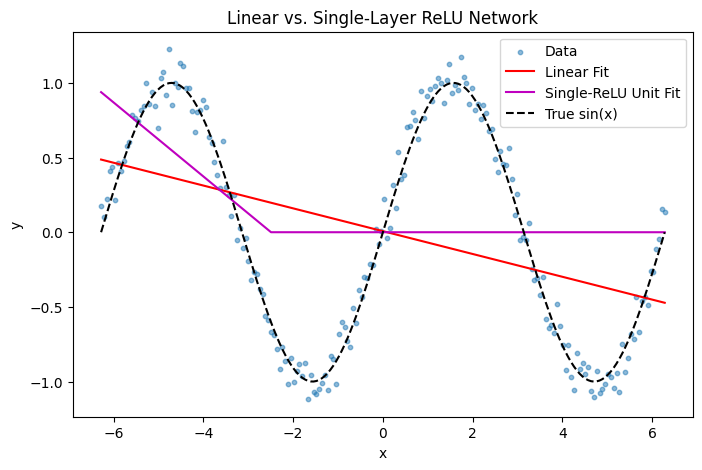

In [ ]:
# 1) Synthetic data
np.random.seed(0)
x = np.linspace(-2*np.pi, 2*np.pi, 200).reshape(-1, 1)
y = np.sin(x) + 0.1*np.random.randn(*x.shape)

# 2) Linear regression (closed-form)
X = np.hstack([x, np.ones_like(x)])
w_lin, b_lin = np.linalg.inv(X.T @ X) @ X.T @ y
y_lin = w_lin * x + b_lin

# 3) Single-layer network: one linear transformation + ReLU activation
#    y_pred = ReLU(w * x + b)
w = np.random.randn(1,1) * 0.1
b = np.zeros(1)
lr, epochs = 0.01, 20000

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

for _ in range(epochs):
    # Forward pass
    z = x.dot(w) + b                # (200,1)
    y_pred = relu(z)

    # Compute gradients via MSE loss
    error = y_pred - y             # (200,1)
    dactivation = relu_derivative(z)

    # dL/dz = 2 * error * dactivation / n
    dL_dz = (2 / len(x)) * error * dactivation

    # Gradients wrt parameters
    dL_dw = np.sum(dL_dz * x, axis=0)  # shape (1,)
    dL_db = np.sum(dL_dz, axis=0)      # shape (1,)

    # Update
    w -= lr * dL_dw
    b -= lr * dL_db

y_relu = relu(x.dot(w) + b)

# 4) Plot comparison
plt.figure(figsize=(8,5))
plt.scatter(x, y, s=10, alpha=0.5, label="Data")
plt.plot(x, y_lin, 'r', label="Linear Fit")
plt.plot(x, y_relu, 'm', label="Single-ReLU Unit Fit")
plt.plot(x, np.sin(x), 'k--', label="True sin(x)")
plt.legend()
plt.title("Linear vs. Single-Layer ReLU Network")
plt.xlabel("x")
plt.ylabel("y")
plt.show()




3. **One Hidden Layer with Multiple Units (Blue)**  
   - Stack two linear layers with activation in between and use several hidden units:  
     ```  
     h = W₁·x + b₁  
     a = σ(h)  
     ŷ = W₂·a + b₂  
     ```  
   - Each hidden unit adds its own shifted/scaled activation. Summing these lets the network build up multiple “bumps” or wiggles.  
   - Training all weights by gradient descent aligns each unit’s activation to different parts of the input, producing a flexible curve that closely matches sin(x).



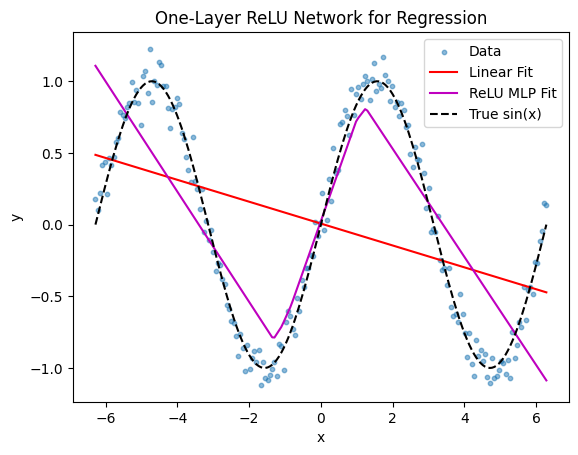

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Create data
np.random.seed(0)
x = np.linspace(-2*np.pi, 2*np.pi, 200).reshape(-1,1)
y = np.sin(x) + 0.1*np.random.randn(*x.shape)

# 2) Linear regression (closed-form)
X = np.hstack([x, np.ones_like(x)])
w_lin, b_lin = np.linalg.inv(X.T @ X) @ X.T @ y
y_lin = w_lin * x + b_lin

# 2) Initialize parameters
H = 20            # hidden size
W1 = np.random.randn(1, H) * 0.1
b1 = np.zeros(H)
W2 = np.random.randn(H, 1) * 0.1
b2 = np.zeros(1)

# 3) Training settings
lr, epochs = 0.01, 2000

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

for _ in range(epochs):
    # Forward pass
    h = x.dot(W1) + b1           # (n, H)
    a = relu(h)                  # ReLU activation
    y_pred = a.dot(W2) + b2      # (n, 1)

    # Compute gradients (MSE loss)
    error = y_pred - y           # (n, 1)
    dW2 = (2/len(x)) * a.T.dot(error)      # (H, 1)
    db2 = (2/len(x)) * np.sum(error)       # scalar

    # Backprop into hidden layer
    da = error.dot(W2.T)                   # (n, H)
    dh = da * relu_derivative(h)           # (n, H)

    dW1 = (2/len(x)) * x.T.dot(dh)         # (1, H)
    db1 = (2/len(x)) * np.sum(dh, axis=0)  # (H,)

    # Parameter updates
    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1

# 4) Plot results
plt.scatter(x, y, s=10, label="Data", alpha=0.5)
plt.plot(x, y_lin, 'r', label="Linear Fit")
plt.plot(x, y_pred, 'm', label="ReLU MLP Fit")
plt.plot(x, np.sin(x), 'k--', label="True sin(x)")
plt.legend()
plt.title("One-Layer ReLU Network for Regression")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


**Key Insight:**  
- **Depth** (layers) lets you compose simple transformations into more complex ones.  
- **Width** (units per layer) lets you combine multiple simple shapes into arbitrary functions.  

This recipe—linear maps + activations + gradient descent—is the foundation of all neural networks, for both regression and classification.  


### Open Questions

Do not use pytorch or any other existing framework for the following problems, implement by yourself! 

1. **Adding Another Layer**  
   - Extend the current one-hidden-layer MLP by inserting a second hidden layer (e.g. `x → Linear → Activation → Linear → Activation → Linear → output`).  
   - Derive the backpropagation formulas for all weight and bias gradients by hand, then implement the training loop yourself. How does a deeper network’s fit compare?

2. **Visualizing the Loss Surface**  
   - For our simple regression model (slope `w` and intercept `b`), plot the MSE loss as a function of `(w,b)` and overlay the gradient descent trajectory.  
   - In this MLP setting (with more parameters), is it feasible to visualize the full loss landscape? If not, what kind of 2D or 3D slices could you plot to gain intuition?

3. **Speeding Up Training**  
   - Our implementation uses full-batch gradient descent and pure Python loops. Name at least three strategies to make training faster (e.g., algorithmic, hardware, or software-level improvements). Which would you try first? Can you try one?

4. **Experimenting with Activations**  
   - Replace the hidden-layer activation (`tanh`) with other functions (ReLU, Leaky ReLU, ELU, etc.). Re-run training and compare final MSE and convergence speed. How does the choice of activation affect model performance and training dynamics?


## Section 3 — MLP Tiny Project on MNIST

Train a small Multilayer Perceptron (MLP) on MNIST using PyTorch. You’ll find countless online tutorials—our goal is not to hand-hold through the basics, but to push you to ask your own questions and use experiments to answer them. Pick one of the example questions below (or come up with your own), then design data-driven experiments and visualizations to support your conclusions. You are welcome to go from the theoy side but this is hard.

**Base setup (suggested)**  
- Architecture: 4-layer MLP (e.g. explore your architecture based on the question you choose)  
- Optimizer: SGD (feel free to change the optimizer based on the question you ask)
- Training loop: train to convergence on the 80% training images, evaluate on the 20% test images  

---

### Example Questions

1. **Activation Functions**  
   - Keep the architecture and optimizer fixed. Swap hidden-layer activations (ReLU, tanh, ELU, etc.).  
   - Compare final test accuracy, convergence speed (loss vs. epoch), and weight distributions in each layer.  
   - How does activation choice affect learning dynamics and performance?

2. **Depth vs. Accuracy**  
   - Vary the number of hidden layers (1 → 2 → … → 6 ), may be more.  
   - Plot “number of layers” vs. test accuracy. Can you reach 100% on the training set? On the test set?  
   - If deeper nets improve, try a harder dataset (e.g. Fashion-MNIST). What breaks, and why? Design controlled experiments to confirm your hypothesis.

3. **Width vs. Depth**  
   - For a fixed parameter budget, compare a “deep” network (many narrow layers) to a “wide” network (few wide layers).  
   - Which trains faster? Which generalizes better? Use training curves and test accuracy to support your conclusions. Try to explain why.

4. **Training Dynamics & Visualization**  
   - Track and plot, per layer:  
     - Training & validation loss curves  
     - Weight histograms  
     - Gradient norms  
   - What patterns emerge (vanishing/exploding gradients, dead neurons, etc.)? How do these insights help you diagnose and improve training?

5. **Initialization Effects**  
   - Compare different parameter initializations (zero, small random, Xavier/He).  
   - Measure their impact on convergence speed, final accuracy, and weight distributions.  
   - Why do some initializations lead to faster or more stable training?

---

### Deliverables

- **Code repository** with your experiments (PyTorch notebooks or scripts).  
- **Visualizations** that clearly support your answers (plots, tables).  
- Write it up or Put them into your slide if you have time. In addition, you can also put incomplete results if you do not have enough time.

Feel free to **collaborate**, share code snippets, and discuss results—just be sure that each student tackles a distinct question and can explain their own findings. Collaboration is encouraged